In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from scipy import stats
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('Consumidores.csv')
df.head()

,Timestamp,Qual sua faixa etária?,Qual seu gênero?,Você se considera um consumidor de Cachaça?,Você costuma consumir Cachaças Artesanais?,"Antes da pandemia, costumava comprar Cachaça online ou de maneira física?","Atualmente, na pandemia, costuma comprar Cachaça online ou de maneira física?",Quais destas bebidas você estaria disposto a comprar?,Por qual lugar você ficaria sabendo onde comprar?,Quais dessas Cachaças da Sanhaçu você teria interesse em comprar?
0,2021/05/10 10:09:13 PM GMT-3,18-28,Masculino,Não,Não,NaN,NaN,Cachaça;Gim;Cerveja;Whisky;Vodka;Rum;Tequila,"Propagandas na internet;Redes Socias(Twitter, ...",Freijó - Freijó é uma madeira da Amazônia que ...
1,2021/05/10 10:10:07 PM GMT-3,18-28,Masculino,Não,Não,Físico,Físico,Cachaça;Gim;Cerveja;Whisky;Vodka;Champanhe,Propagandas na internet,Carvalho - O carvalho é uma madeira importada....
2,2021/05/10 10:11:59 PM GMT-3,18-28,Masculino,Não,Não,NaN,NaN,NaN,NaN,NaN
3,2021/05/10 10:12:23 PM GMT-3,28-38,Masculino,Sim,Não,Físico,Físico,Cachaça;Gim;Cerveja;Whisky;Vodka;Rum;Champanhe...,"Redes Socias(Twitter, Instagram)",Umburana - Madeira encontrada em várias regiõe...
4,2021/05/10 10:12:47 PM GMT-3,48+,Masculino,Sim,Sim,Físico,Físico,Cachaça;Vodka,TV,"Origem - A Sanhaçu ORIGEM, como diz o nome, é ..."


#Tratamento de dados
Tendo em vista que retiramos dados de um google forms, é possivel que alguns dados estejam nulos(não preenchidos). Por esse motivos optamos por substituir esses valores por 0, pois isso indica que o usuário não realizou o evento o qual esvamos perguntando.

Ex:  No campo de "Quais destas bebidas você estaria disposto a comprar?" existem valores nulos que signica que o usuário não estaria disposto a adquirir nenhuma das opções dadas, nesse caso 0 representaria o grupo que não está disposto a adquirir nenhuma bebida.

Além disso, decidimos retirar a coluna de timestamp até o momento, pois atualmente ela apenas como um "user_id".

Para transformação dos dados, utilizamos um LabelEncoder() e normalizamos utilizando StandardScaler(). Para dados Categóricos normalmente se utiliza o OneHotEncoder(), porém como o formato dos dados fornecidos pelo forms tem uma particularidade, decidimos seguir com nossa própria implementação de um Transformer.

O principal motivo dessa escolha é que o OneHotEncoder iria criar uma coluna para cada categoria, porem tem categorias que contém mais de uma. Como por exemplo:

`Cachaça;Gim;Cerveja;Whisky;Vodka;Rum;Tequila` -> nesse caso o OneHotEncoder iria criar uma categoria exclusivamente para essa combinação e com a nossa implementação utilizamos apenas uma coluna para cada categoria(Cerveja, Tequila, Rum, ...) e preenchemos de forma binária. Assim reduzindo a dimensionalidade e ainda continua tratando as categorias de forma isolada.

In [ ]:
columns = ['timestamp','Faixa_etaria', 'Genero', 'Consumidor_de_cachaca', 'Consumir_cachaca_artesanal',
              'Compras_antes_pandemia', 'Compras_durante_pandemia', 'Bebidas_dispostos_a_comprar',
              'Meio_de_divulgacao', 'produtos_sanhacu']
df.columns = columns

df.fillna(0, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   timestamp                    101 non-null    object
 1   Faixa_etaria                 101 non-null    object
 2   Genero                       101 non-null    object
 3   Consumidor_de_cachaca        101 non-null    object
 4   Consumir_cachaca_artesanal   101 non-null    object
 5   Compras_antes_pandemia       101 non-null    object
 6   Compras_durante_pandemia     101 non-null    object
 7   Bebidas_dispostos_a_comprar  101 non-null    object
 8   Meio_de_divulgacao           101 non-null    object
 9   produtos_sanhacu             101 non-null    object
dtypes: object(10)
memory usage: 8.0+ KB


In [ ]:
class DummyTransformer(TransformerMixin, BaseEstimator):    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        columns = ['Bebidas_dispostos_a_comprar', 
                   'Meio_de_divulgacao', 
                   'produtos_sanhacu','Compras_antes_pandemia',
                   'Compras_durante_pandemia']

        for column in columns:
            str1 = ''.join(str(e)+';' for e 
                        in df[column].unique())
                    
            set1 = set(str1.split(';'))

            if '' in set1:
                set1.remove('')
            if '0' in set1:
                set1.remove('0')

            for val in set1:
                val = val.split("-")[0]
                df[val] = pd.Series([0 for x in range(len(df.index))])
                df[val] = df[column].apply(lambda x: (1 if str(val) in str(x) else 0))
            
        return X

In [ ]:
def encode_column(columns, encoder):
    for column in columns:
        df[column] = df[column].astype(str)
        df[column] = encoder.fit_transform(df[column]).reshape(-1, 1)

label = ['timestamp','Faixa_etaria', 'Genero', 'Consumidor_de_cachaca', 'Consumir_cachaca_artesanal']

label_encoder = LabelEncoder()

encode_column(label, label_encoder)
dummy = DummyTransformer()

df = dummy.fit_transform(df)

df.drop(columns=['timestamp', 'Bebidas_dispostos_a_comprar',
                 'Meio_de_divulgacao', 'produtos_sanhacu',
                 'Compras_antes_pandemia',
                 'Compras_durante_pandemia'], inplace=True)
df.head()

,Faixa_etaria,Genero,Consumidor_de_cachaca,Consumir_cachaca_artesanal,Tequila,Gim,Cachaça,Rum,Whisky,Champanhe,Vodka,Cerveja,Boca a Boca,"Redes Socias(Twitter, Instagram)",Propagandas na internet,TV,Influenciadores,Carvalho,Origem,Freijó,Umburana,Online,Físico
0,1,2,1,1,1,1,1,1,1,0,1,1,0,1,1,0,0,1,1,1,1,0,0
1,1,2,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,1,0,0,0,0,1
2,1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,2,2,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,1,0,1
4,4,2,2,2,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1


In [ ]:
#normalização
col = df.columns
scaler = StandardScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df,columns = col)

In [ ]:
df.head()

,Faixa_etaria,Genero,Consumidor_de_cachaca,Consumir_cachaca_artesanal,Tequila,Gim,Cachaça,Rum,Whisky,Champanhe,Vodka,Cerveja,Boca a Boca,"Redes Socias(Twitter, Instagram)",Propagandas na internet,TV,Influenciadores,Carvalho,Origem,Freijó,Umburana,Online,Físico
0,-0.565488,0.693782,-0.702757,-0.671836,1.614665,1.115547,1.071884,2.304886,1.115547,-0.650027,1.138180,0.588784,-1.209717,0.809776,1.185227,-0.481360,-0.588784,1.260850,1.614665,1.614665,0.990148,-0.60404,-1.030158
1,-0.565488,0.693782,-0.702757,-0.671836,-0.619324,1.115547,1.071884,-0.433861,1.115547,1.538397,1.138180,0.588784,-1.209717,-1.234909,1.185227,-0.481360,-0.588784,1.260850,-0.619324,-0.619324,-1.009950,-0.60404,0.970725
2,-0.565488,0.693782,-0.702757,-0.671836,-0.619324,-0.896421,-0.932936,-0.433861,-0.896421,-0.650027,-0.878595,-1.698416,-1.209717,-1.234909,-0.843721,-0.481360,-0.588784,-0.793116,-0.619324,-0.619324,-1.009950,-0.60404,-1.030158
3,0.299880,0.693782,1.215579,-0.671836,1.614665,1.115547,1.071884,2.304886,1.115547,1.538397,1.138180,0.588784,-1.209717,0.809776,-0.843721,-0.481360,-0.588784,-0.793116,-0.619324,-0.619324,0.990148,-0.60404,0.970725
4,2.030616,0.693782,1.215579,1.266890,-0.619324,-0.896421,1.071884,-0.433861,-0.896421,-0.650027,1.138180,-1.698416,-1.209717,-1.234909,-0.843721,2.077448,-0.588784,-0.793116,1.614665,-0.619324,-1.009950,-0.60404,0.970725


#KMeans Clustering


## Selecionando e criando um modelo
Como nosso objetivo é identificar o perfil do nosso usuário, aplicamos uma tecnica de aprendizagem não-supervisionada utilizando KMeans().

Treinamos o modelo com quantidade de 1 até 15 clusters. Fizemos a utilização de um gráfico do cotovelo utilizando da distorção para defirnir a melhor quantidade de clusters, porém não conseguimos identificar a melhor quantidade utilizando somente essa técnica. Devido a isso, partimos para uma avaliação utilizando o método da silhueta.

No método da silhueta, chegamos a conclusão que o melhor número de clusters é 7, pois no gráfico de 7 clusters todos os pontos estão acima da média de silhoutte_score. Não escolhemos 5 ou 8 clusters pela consistencia dos clusters, que apresentão diferenças nas 'larguras'. Por fim, decidimos continuar com o número de clusters = 7.

Também utilizamos o método de calculo de distancia entre os clusters. E podemos validar que existe uma boa relação entra as distancias.

Após o treinamento e seleção de número de cluster utilizamos um PCA() para reduzir a dimensionalidade da predição e após isso plotar uma visualização do cluster.

---------------

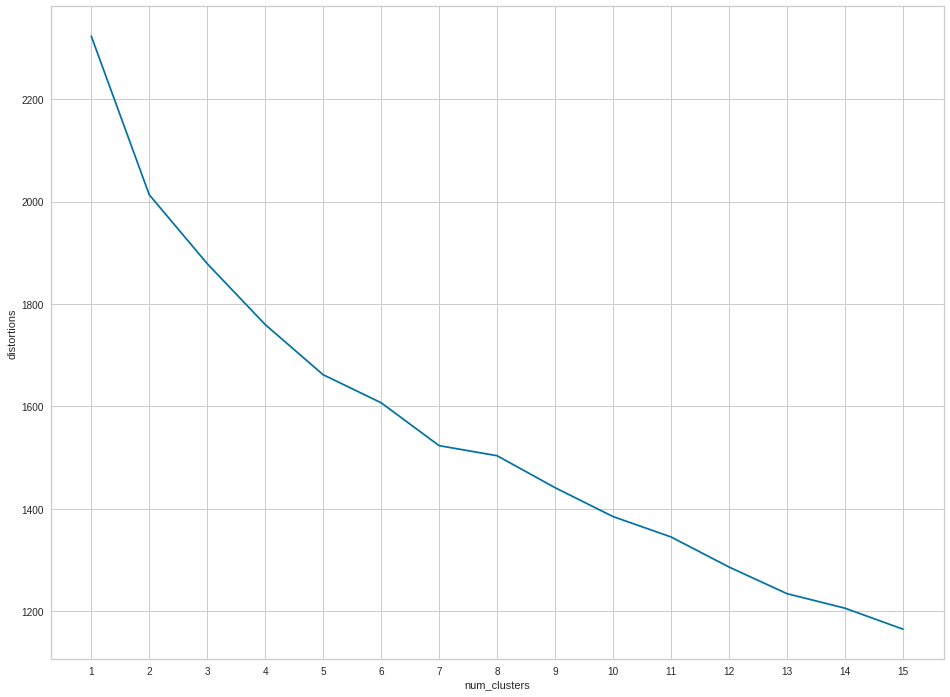

In [ ]:
distortions = []
num_clusters =  range(1,16)


for n in num_clusters:
    print("-", end = '')
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(df)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize=(16, 12))    
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

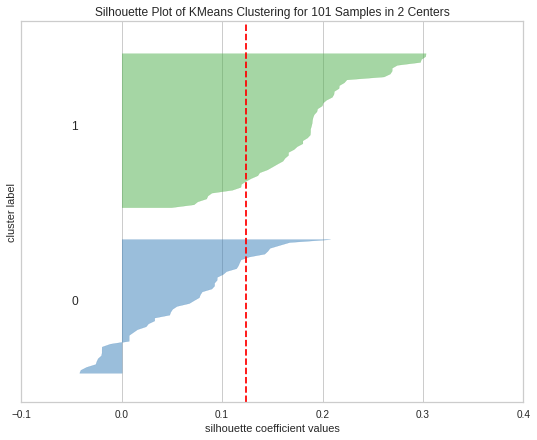

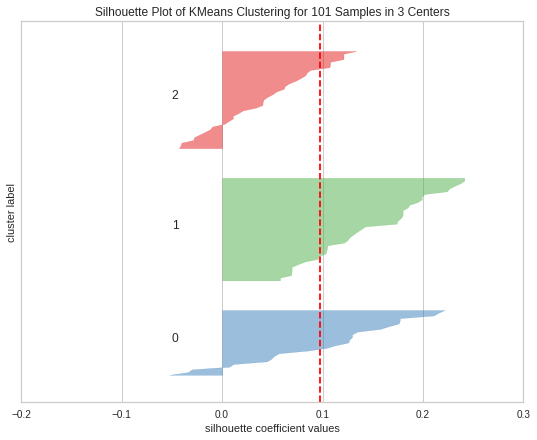

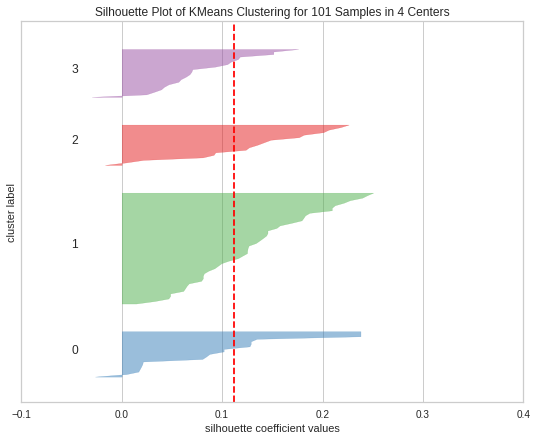

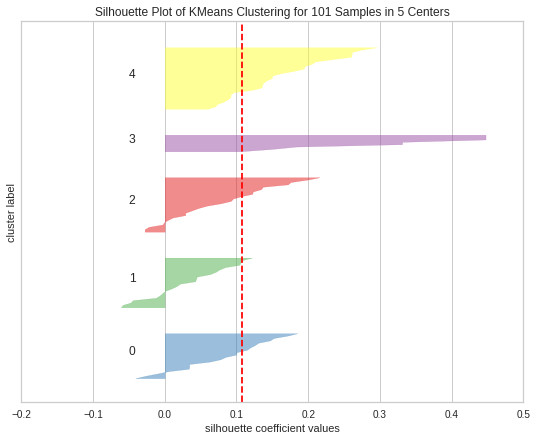

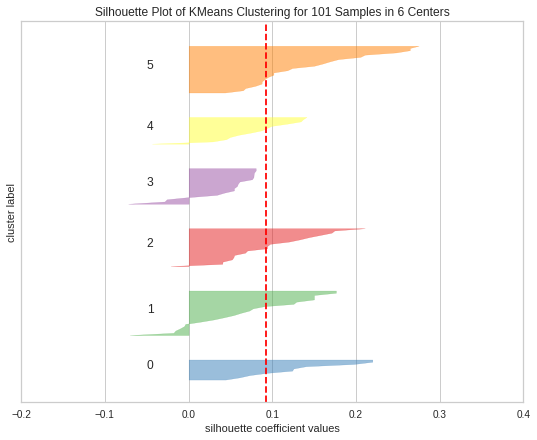

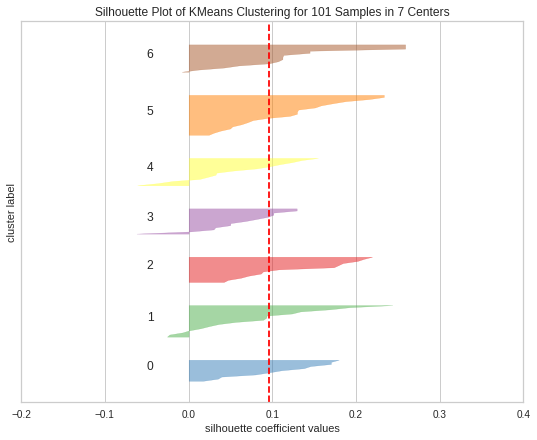

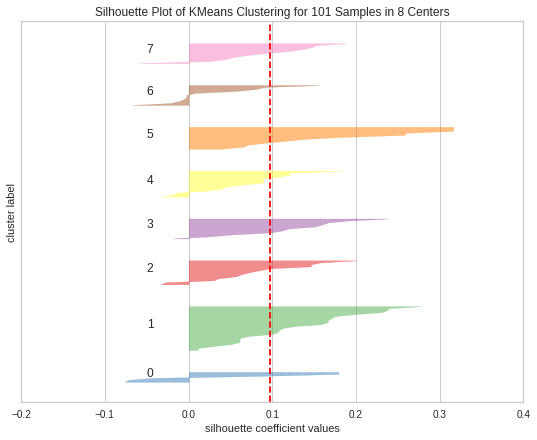

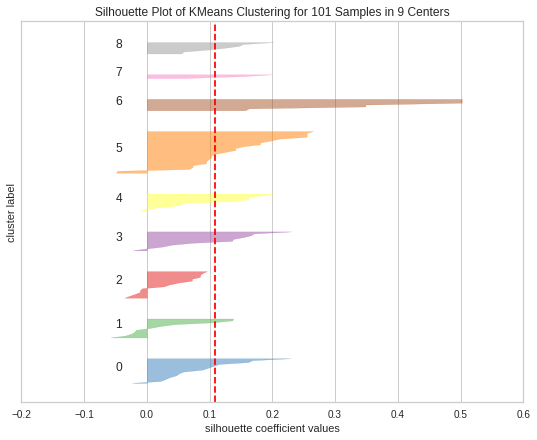

In [ ]:
for i in range(2,10):
    fig = plt.figure(figsize=(9, 7))
    model = KMeans(i, random_state=42)
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(df)
    visualizer.poof()

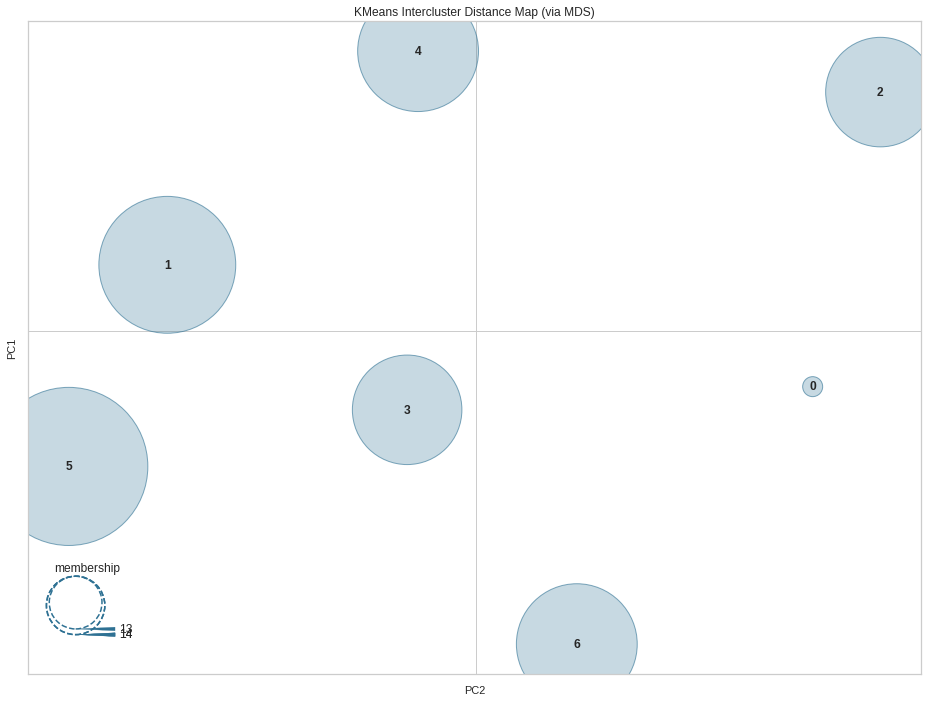

In [ ]:
fig = plt.figure(figsize=(16, 12))
model = KMeans(7, random_state=42)
visualizer = InterclusterDistance(model)
visualizer.fit(df)
visualizer.poof()    

In [ ]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(df)
cluster_pred = kmeans.predict(df)
print("kmeans Predict:\n{}\n".format(cluster_pred))
print("Clustering Score:\n{}".format(kmeans.inertia_))

kmeans Predict:
[2 3 4 2 6 4 5 4 3 4 2 5 3 3 0 2 3 3 4 4 6 4 3 4 4 3 2 4 6 2 1 2 2 4 3 1 1
 2 6 4 4 6 4 1 1 2 1 6 6 4 0 4 1 3 0 6 3 4 1 4 3 2 3 4 3 3 4 0 2 1 6 1 3 2
 4 0 4 1 3 3 2 0 6 2 5 0 5 4 1 3 6 1 1 1 6 1 6 2 6 2 1]

Clustering Score:
1533.2807684950044


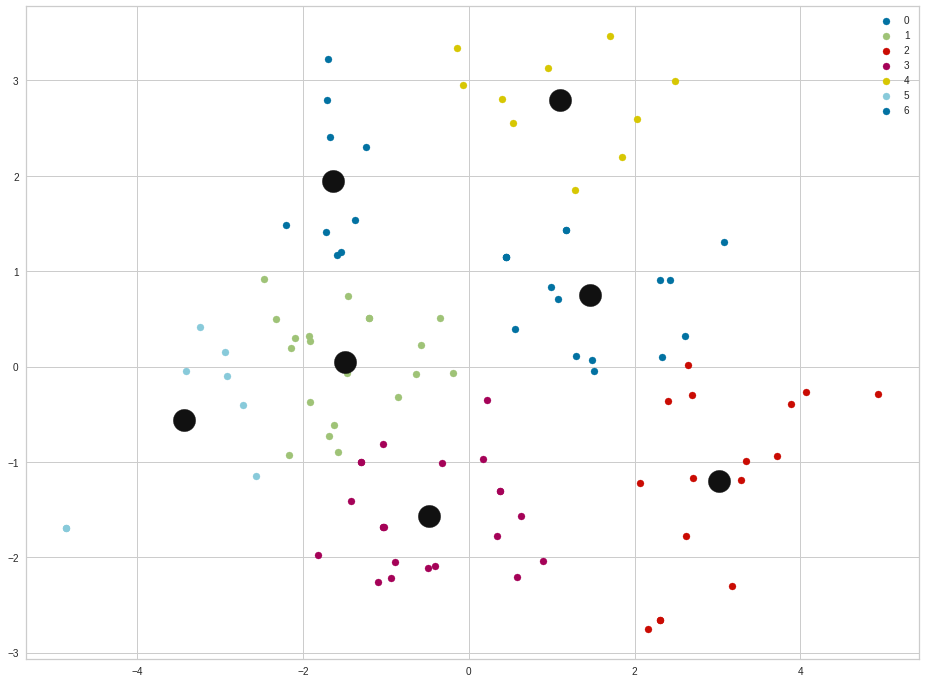

In [ ]:
pca = PCA(2)

df = pca.fit_transform(df)
label = kmeans.fit_predict(df)
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)

fig = plt.figure(figsize=(16, 12))

for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 500, color = 'k')
plt.legend()
plt.show()

In [ ]:
df = pd.read_csv('Consumidores.csv')
df['Clusters'] = cluster_pred
df = df.sort_values('Clusters')
df.to_csv('clusters.csv')

#Collaborative Filtering